# Import Python Libraries

In [1]:
# import needed libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.utils import shuffle
import csv
import os
import math

In [2]:
from utility import *
import keras
from keras.models import Sequential 
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

Using TensorFlow backend.


# Load Data Set

In [3]:
#load data in form of np array
data_b = np.load('images_benign_50.npy')
print("# benign:", data_b.shape)

data_m = np.load('images_mali_50.npy')
print("# malignant:", data_m.shape) 

dim = int(math.sqrt(data_b.shape[1] / 3 )) # dimension of the image
print("dimension of images:", dim)

# benign: (8061, 7500)
# malignant: (1954, 7500)
dimension of images: 50


In [4]:
#vertically stack files
data = np.vstack((data_b,data_m))
print("original data shape:", data.shape)

# create labelset (benign = 1, malignant = 2)
label_b = np.ones((data_b.shape[0],1),dtype=np.uint8) # an array of all zeros
label_m = np.ones((data_m.shape[0],1),dtype=np.uint8) * 2 # an array of all ones
label = np.vstack((label_b,label_m)) # all label

original data shape: (10015, 7500)


## train test separation

In [5]:
data_train, label_train, data_test, label_test = train_test_shuffled_separation(data, label, train_percent= 0.8)

shuffled data shape: (10015, 7500) shuffled label shape: (10015,)
# train: 8012
# test:  2003
# total: 10015


## convert label (1/2) to one hot code

In [6]:
label_train = label_to_one_hot(label_train)
label_test = label_to_one_hot(label_test)

## reshape image arrays to N x size x size x 3

In [7]:
data_train = data_train.reshape((data_train.shape[0], dim, dim, 3))
data_test = data_test.reshape((data_test.shape[0], dim, dim, 3))

## normalize image arrays to 0 - 1 

In [8]:
data_train = normalize_data(data_train)
data_test = normalize_data(data_test)
print("image size:", data_train.shape[1:])

image size: (50, 50, 3)


# Display images from dataset

In [9]:
# function to display the images
def list_images(data, label, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(data))
        
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data[indx].shape) == 2 else cmap
        plt.imshow(data[indx], cmap = cmap)
        
        plt.xlabel("Benign" if label[indx][0] == 1 else "Malignant")
        #plt.ylabel(ylabel)
        
        plt.xticks([])
        plt.yticks([])
    #plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

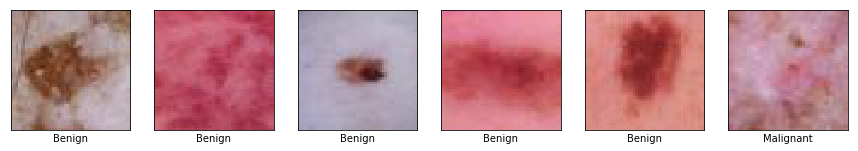

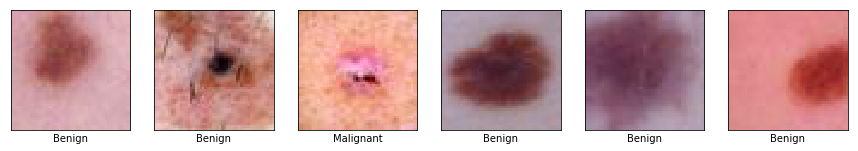

In [10]:
# plot the sample images
list_images(data_train, label_train)
list_images(data_test, label_test)

# Data Preprocessing

In [11]:
# convert images to gray scale
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# VGG-13 implemented in keras

In [12]:
VGG13_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: 2x Conv + Maxpool
# 3 -> 32 feature maps
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(dim, dim, 3), name='block1_conv1'))
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: 2x Conv + Maxpool
# 32 -> 64 feature maps
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))
VGG13_model.add(Dropout(0.25)) # dropout = 0.25

# block 3: 2x Conv + Maxpool
# 64 -> 128 feature maps
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block3_pool'))

# block 4: 2x Conv + Maxpool
# 128 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block4_pool'))

# block 5: 2x Conv + Maxpool
# 256 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block5_pool'))

# block 6: 3x FC
VGG13_model.add(Flatten(name='block6_flatten'))
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc1'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc2'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(2, activation='sigmoid', name='predictions')) # output two classes

### compile the VGG-13 architecture

In [29]:
# optimizer
# Adam
# AdaDelta
# SGD
SGD = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
VGG13_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
data_train.shape

(8012, 50, 50, 3)

for i in range(len(VGG13_model.layers)):
               print(VGG13_model.layers[i].output)

### start training VGG-13

In [15]:
history = VGG13_model.fit(data_train, label_train, batch_size=32, epochs=10, validation_split=0.1)#validation_data=(data_valid, label_valid)

Train on 7210 samples, validate on 802 samples
Epoch 1/10
7210/7210 [==============================] - 13s 2ms/step - loss: 0.5002 - acc: 0.8064 - val_loss: 0.5134 - val_acc: 0.7893
Epoch 2/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4663 - acc: 0.8076 - val_loss: 0.4584 - val_acc: 0.7893
Epoch 3/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4493 - acc: 0.8076 - val_loss: 0.5123 - val_acc: 0.7893
Epoch 4/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4461 - acc: 0.8076 - val_loss: 0.4361 - val_acc: 0.7893
Epoch 5/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4305 - acc: 0.8076 - val_loss: 0.4338 - val_acc: 0.7893
Epoch 6/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4329 - acc: 0.8076 - val_loss: 0.4373 - val_acc: 0.7893
Epoch 7/10
7210/7210 [==============================] - 8s 1ms/step - loss: 0.4285 - acc: 0.8076 - val_loss: 0.4318 - val_acc: 0.7893
Epoch 8/10
721

### evaluate trained VGG-13 model

In [16]:
score, acc = VGG13_model.evaluate(data_test, label_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

2003/2003 [==============================] - 1s 321us/step
Test score: 0.3940868415477808
Test accuracy: 0.8012980527718306


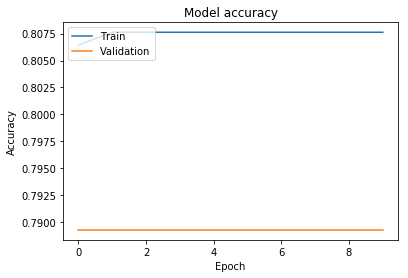

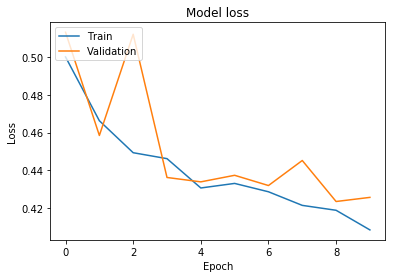

In [17]:
plot_history(history)

In [28]:
from keras import backend as K
layer = 'block1_conv2'
index = 0

layer_output = VGG13_model.layers[1].output
loss = K.mean(layer_output[:,:,:, index])

grads = K.gradients(loss, data_train[0,:])
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([input_img], [loss, grads])


# LeNet-5 implemented in keras

![LeNet-5](https://cdn-images-1.medium.com/max/1500/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [18]:
LeNet5_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: Conv + Maxpool
# 3 -> 6 feature maps
LeNet5_model.add(Conv2D(6, (3,3), activation='relu', padding='valid', input_shape=(dim, dim, 3), name='block1_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: Conv + Maxpool
# 6 -> 16 feature maps
LeNet5_model.add(Conv2D(16, (3,3), activation='relu', padding='same', name='block2_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))

# block 3: 3x FC
LeNet5_model.add(Flatten(name='block6_flatten'))
LeNet5_model.add(Dense(120, activation='relu', name='block3_fc1'))
LeNet5_model.add(Dense(84, activation='relu', name='block3_fc2'))
LeNet5_model.add(Dense(2, activation='sigmoid', name='predictions')) # output two classes

### compile LeNet-5 architecture

In [19]:
# optimizer
# Adam
# AdaDelta
# SGD
LeNet5_model.compile(optimizer='AdaDelta', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
data_train.shape

(8012, 50, 50, 3)

In [21]:
for i in range(len(LeNet5_model.layers)):
               print(LeNet5_model.layers[i].output)

Tensor("block1_conv1_1/Relu:0", shape=(?, 48, 48, 6), dtype=float32)
Tensor("block1_pool_1/MaxPool:0", shape=(?, 24, 24, 6), dtype=float32)
Tensor("block2_conv1_1/Relu:0", shape=(?, 24, 24, 16), dtype=float32)
Tensor("block2_pool_1/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
Tensor("block6_flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("block3_fc1/Relu:0", shape=(?, 120), dtype=float32)
Tensor("block3_fc2/Relu:0", shape=(?, 84), dtype=float32)
Tensor("predictions_1/Sigmoid:0", shape=(?, 2), dtype=float32)


### start training LeNet-5

In [22]:
history = LeNet5_model.fit(data_train, label_train, batch_size=32, epochs=10, validation_split=0.1)#validation_data=(data_valid, label_valid)

Train on 7210 samples, validate on 802 samples
Epoch 1/10
7210/7210 [==============================] - 3s 370us/step - loss: 0.4837 - acc: 0.8076 - val_loss: 0.4886 - val_acc: 0.7893
Epoch 2/10
7210/7210 [==============================] - 2s 288us/step - loss: 0.4469 - acc: 0.8076 - val_loss: 0.4492 - val_acc: 0.7905
Epoch 3/10
7210/7210 [==============================] - 2s 309us/step - loss: 0.4214 - acc: 0.8070 - val_loss: 0.4310 - val_acc: 0.7887
Epoch 4/10
7210/7210 [==============================] - 2s 329us/step - loss: 0.4038 - acc: 0.8098 - val_loss: 0.4308 - val_acc: 0.7905
Epoch 5/10
7210/7210 [==============================] - 3s 405us/step - loss: 0.3897 - acc: 0.8207 - val_loss: 0.3994 - val_acc: 0.7911
Epoch 6/10
7210/7210 [==============================] - 2s 325us/step - loss: 0.3795 - acc: 0.8244 - val_loss: 0.3943 - val_acc: 0.8055
Epoch 7/10
7210/7210 [==============================] - 2s 302us/step - loss: 0.3679 - acc: 0.8294 - val_loss: 0.3744 - val_acc: 0.8198
E

### evaluate trained LeNet-5 model

In [23]:
score, acc = LeNet5_model.evaluate(data_test, label_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

2003/2003 [==============================] - 0s 180us/step
Test score: 0.40307552250277917
Test accuracy: 0.8152770844031976


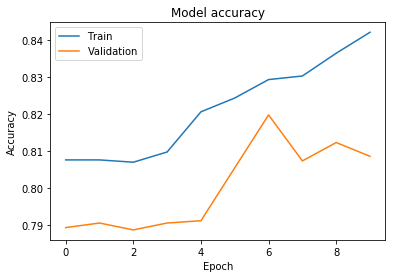

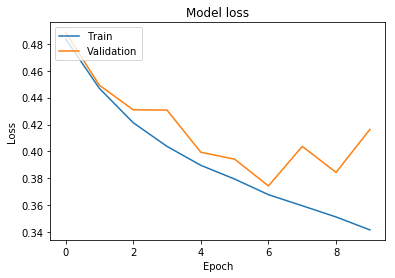

In [24]:
plot_history(history)